## Modèle en production

Laurent Cetinsoy - Datadidacte

Une des supposition centrale pour qu'un modèle de machine learning marche est que la distribution des données ne diffère pas de celle des données d'entrainement.

On ne peut garantir la généralisation d'un modèle que si la distribution des données est similaire à celle de la distribution $ X_{prod} \tilde{} \,  P_{train}$

Ainsi, si les données que le modèle voient en production n'ont pas la même distribution (ne ressemblent pas) aux données de train, alors le modèle aura peu de chance de faire de bonne prédictions.

Il est donc important de surveille les données vues par le modèle en production.

Pour cela on va mesurer ce qu'on appelle le Data drift : on va mesurer à quel point les données s'écartent des données de train.

Et on pourra ainsi lever une alerte si c'est le cas.

## Utilisation Eurybia



En consultant la documentation de Eurybia (https://eurybia.readthedocs.io/en/latest/overview.html), expliquer le principe de fonctionnement de Euribya :

- A quoi sert le modèle de classification ?
- A-t-on besoin d’avoir les labels issus de la production pour pouvoir utiliser cette approche ?
- Quel est le critère pour déterminer qu’il y a un data-drift ?


Eurybia est une bibliothèque Python qui permet de surveiller les modèles en productionet notamment de détecter le data drift, c'est-à-dire un changement dans la distribution des données entre l’entraînement et la production.

Le principe repose sur l’entraînement d’un classifieur de drift : on construit un problème de classification binaire où les données de train sont étiquetées 0 et les données de production sont étiquetées 1. Si ce modèle parvient à distinguer efficacement les deux jeux de données, cela signifie que leurs distributions diffèrent et qu’il existe un drift.

Cette approche ne nécessite pas de disposer des labels réels en production car seuls les informations d’entrée sont utilisés pour comparer les distributions.

Le critère principal pour déterminer la présence d’un drift est la performance du classifieur, mesurée par l’AUC : une AUC proche de 0.5 signifie qu’il n’y a pas de drift notable (le classifieur ne distingue pas les deux ensembles) et une AUC élevée (vers 0.7 et plus) indique que les distributions divergent et qu’il y a un drift.

Installer eurybia

In [1]:
# !pip install eurybia

Utiliser eurybia pour monitorer la distribution des données. Dans un premier temps faire en sorte que les données de prod (df_current) soient de la même distribution que vos données d’entraînement. Pour cela vous pouvez split le dataset en deux et décider que l'un est X_train et l'autre est X_prod. Vérifier que Eurybia pense que le modèle ne drift pas. Attention à ne pas inclure le label (qui serait ici price)



In [2]:
import tempfile, os, base64
from IPython.display import IFrame

def print_eurybia_report(sd):
    with tempfile.NamedTemporaryFile(suffix=".html", delete=False) as tmp:
        tmp_path = tmp.name
        
    sd.generate_report(tmp_path)
    
    with open(tmp_path, "rb") as f:
        data_uri = "data:text/html;base64," + base64.b64encode(f.read()).decode("utf-8")
    
    display(IFrame(src=data_uri, width="100%", height=700))
    
    os.remove(tmp_path)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from eurybia import SmartDrift

df = pd.read_csv("houses_2024.csv", sep=",")

X = df.drop(columns=["price"])
X_train, X_prod = train_test_split(X, test_size=0.5, random_state=42)

sd = SmartDrift(
    df_current=X_prod,
    df_baseline=X_train
)

sd.compile()

print("Drift AUC:", sd.auc)

print_eurybia_report(sd)

/home/julien/Files/ING3/MLOps-and-embedded-ML-2026/Datadrift/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7fb873038750>
Drift AUC: 0.5118047218887555


Faire en sorte d'introduire un drift dans vos données. Par exemple (méthode assez bourine) ajouter +3 ou +4 à la colonne nb_rooms. Relancer eurybia et vérifier que la performance du modèle est bonne et qu'il y a donc un datadrift

In [4]:
X_prod_drift = X_prod.copy()
X_prod_drift["nb_rooms"] = (X_prod_drift["nb_rooms"] + 3).astype(int)

sd_drift = SmartDrift(
    df_current=X_prod_drift,
    df_baseline=X_train
)

sd_drift.compile()
print(f"AUC (après drift) = {sd_drift.auc:.3f}")

print_eurybia_report(sd_drift)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7fb86d93a550>
AUC (après drift) = 1.000


On observe effectivement un datadrift flagrant (AUC = 1).

Faire en sorte de faire un drift plus subtile mais remarquable. Est-il détectable avec Eurybia ?

In [5]:
X_prod_drift = X_prod.copy()
X_prod_drift["size"] = X_prod_drift["size"] * 1.05

mask = X_prod_drift["orientation"] == "Est"
X_prod_drift.loc[mask, "orientation"] = "Nord"

sd_drift_subtil = SmartDrift(
    df_current=X_prod_drift,
    df_baseline=X_train
)

sd_drift_subtil.compile()

print(f"AUC (après drift subtil) = {sd_drift_subtil.auc:.3f}")

print_eurybia_report(sd_drift_subtil)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7fb86f7ba190>
AUC (après drift subtil) = 0.582


Dans cet exemple, l’AUC du classifieur de drift est passée à 0.58, ce qui reste supérieur à 0.5. Cela signifie que, même si la séparation entre données de référence et données actuelles n’est pas nette comme dans le cas d’un drift massif, Eurybia parvient tout de même à mettre en évidence une différence de distribution. On peut donc considéré qu'Eurybia est capable de détecter ce drift.

## Alibaba detect

Dans cette partie on va utiliser la librairie https://github.com/SeldonIO/alibi-detect pour faire la détection de problèmes

Installer la librairie avec pip

In [6]:
# !pip install alibi-detect

Charger le jeu de donnée cifar10 avec keras et récupérer le train et le test puis,

Normaliser les données de train en faisant un MinMaxScaling (diviser par 255)

In [7]:
import numpy as np
from tensorflow.keras.datasets import cifar10

# Charger CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Taille train:", X_train.shape, "Taille test:", X_test.shape)

print("Avant normalisation - min:", X_train.min(), "max:", X_train.max())

# Normalisation MinMax [0,1] en divisant par 255
X_train_scaled = X_train.astype("float32") / 255.0
X_test_scaled = X_test.astype("float32") / 255.0

print("Après normalisation - min:", X_train_scaled.min(), "| max:", X_train_scaled.max())

2025-10-03 17:34:23.296812: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-03 17:34:23.337527: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-03 17:34:23.337575: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-03 17:34:23.337608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-03 17:34:23.345010: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-03 17:34:23.345627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Taille train: (50000, 32, 32, 3) Taille test: (10000, 32, 32, 3)
Avant normalisation - min: 0 max: 255
Après normalisation - min: 0.0 | max: 1.0


Dans le sous package alibi_detect.datasets importer les  fonction fetch_cifar10c et corruption_types_cifar10c

In [8]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

Afficher les types de corruption de données disponible avec la fonction corruption_types_cifar10c

In [9]:
corruptions = corruption_types_cifar10c()
print("Corruptions disponibles :")
corruptions

Corruptions disponibles :


['brightness',
 'contrast',
 'defocus_blur',
 'elastic_transform',
 'fog',
 'frost',
 'gaussian_blur',
 'gaussian_noise',
 'glass_blur',
 'impulse_noise',
 'jpeg_compression',
 'motion_blur',
 'pixelate',
 'saturate',
 'shot_noise',
 'snow',
 'spatter',
 'speckle_noise',
 'zoom_blur']

Avec la fonction fetch_cifar10c récupérer des exemples corrompus de donnée ressemblant à cifar 10 et les stocker dans des variable X_corrupted et y_corrupted.

Vous choisirez 1 ou 2 corruptions parmis les suivantes : ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']

Vous spécifirez les argument severity=5 et return_X_y=True
attention le dataset peut être lourd si vous utilisez bcp de corruptions

In [10]:
corruptions = ['gaussian_noise', 'motion_blur']

X_corrupted, y_corrupted = fetch_cifar10c(
    corruptions,
    severity=5,
    return_X_y=True
)

print("Shape X_corrupted:", X_corrupted.shape)
print("Shape y_corrupted:", y_corrupted.shape)
print("Valeurs uniques des labels:", set(y_corrupted))

Shape X_corrupted: (20000, 32, 32, 3)
Shape y_corrupted: (20000,)
Valeurs uniques des labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Normaliser les images corrompues

In [11]:
X_corrupted_scaled = X_corrupted.astype("float32") / 255.0

print("Avant normalisation:", X_corrupted.min(), X_corrupted.max())
print("Après normalisation:", X_corrupted_scaled.min(), X_corrupted_scaled.max())

Avant normalisation: 0.0 255.0
Après normalisation: 0.0 1.0


Afficher plusieurs des images corrompues.

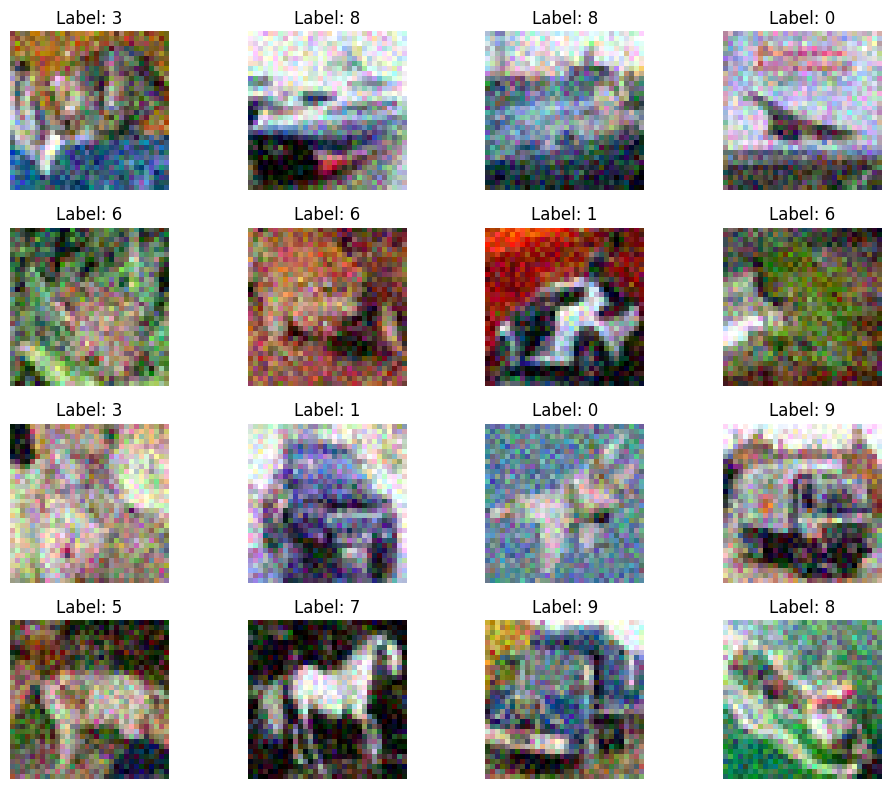

In [12]:
import matplotlib.pyplot as plt

n_images = 16
images = X_corrupted_scaled[:n_images]
labels = y_corrupted[:n_images]

fig, axes = plt.subplots(4, 4, figsize=(10, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

On va maintenant prendre un modèle entraîné sur cifar10 pour voir l'impact des performances sur le modèle.

Avec la fonction  fetch_tf_model du module alibi_detect.utils.fetching, charger le modèle préentraîné resnet32 sur cifar10


In [13]:
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
dataset = 'cifar10'
model_name = 'resnet32'
model = fetch_tf_model(dataset, model_name)

4293464/4293464 [==============================] - 0s 0us/step


Calculer la performance du model sur le jeu de train et de test

In [14]:
from sklearn.metrics import accuracy_score

y_pred_train = model.predict(X_train_scaled, batch_size=256, verbose=0).argmax(axis=1)
y_pred_test  = model.predict(X_test_scaled, batch_size=256, verbose=0).argmax(axis=1)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print(f"Accuracy train : {acc_train:.4f}")
print(f"Accuracy test : {acc_test:.4f}")

2025-10-03 17:34:57.180351: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


Accuracy train : 0.6163
Accuracy test : 0.6042


Calculer la performance du modèle sur le jeu de donnée corrompu. Vous devriez observer qu'il chute significativement

In [15]:
y_pred_corrupted = model.predict(X_corrupted_scaled, batch_size=256, verbose=0).argmax(axis=1)

acc_corrupted = accuracy_score(y_corrupted, y_pred_corrupted)

print(f"Accuracy corrupted : {acc_corrupted:.4f}")

Accuracy corrupted : 0.1585


Effectivement, il y a une chute significative de la performance.

On va maintenant voir comment détecter les changement de distributions de données.

Pour les données non tabulaire ou à haute dimension on procéde généralement en deux étapes :

1. Faire une réduction de dimension
2. Faire un test permettant de voir si les données projetées ont changé de distribution ou pas

Il existe plusieurs manières de faire de la réduction de dimension. La plus classique est la PCA.

Il est possible également d'utiliser des Auto-encoder

Le code suivant permet de créer la première partie (l'encoder) d'un auto-encoder simple qui nous servira à réduire les dimension des données.

In [16]:
import tensorflow as tf
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

Le drift detector a besoin d'une donnée de référence afin d'effectuer la comparaison avec les données à monitorer.
Créer une variable X_ref avec un échantillon aléatoire des données de test

In [17]:
n_ref = 10000
idx = np.random.choice(len(X_test_scaled), size=n_ref, replace=False)
X_ref = X_test_scaled[idx]

print("Shape X_ref:", X_ref.shape)

Shape X_ref: (10000, 32, 32, 3)


A quoi sert le test statistique kolmogorov smirnoff ?

Le test statistique Kolmogorov-Smirnov est un test statistique non paramétrique qui permet de comparer des distributions de données. Il mesure la plus grande différence entre les fonctions de répartition cumulées de deux échantillons.

La page Wikipedia référence deux cas principaux :
- One-sample Kolmogorov-Smirnov test : vérifier si un échantillon suit une distribution théorique donnée (par ex. une loi normale).
- Two-sample Kolmogorov-Smirnov test : comparer deux échantillons pour déterminer s’ils proviennent de la même distribution.

De ce que je comprends, en pratique, le test statistique Kolmogorov-Smirnov test est souvent appliqué variable par variable pour détecter un data drift. Par exemple, on peut comparer la distribution d’une caractéristique entre les données d’entraînement et celles de production. Si la différence est statistiquement significative, on conclut que la variable a changé de distribution et cela peut signaler un problème de drift.

Ce test reste cependant limité à des comparaisons univariées.

Instancier la classe KSDrift dans une variable nommée **detector**

Il faut lui passer le dataset de reference, une p value (prendre 0.05) et une fonction permettant de faire le preprocessing. On a créé la fonction pour vous


In [18]:
from alibi_detect.cd.tensorflow import preprocess_drift
preprocess_function = partial(preprocess_drift, model=encoder_net, batch_size=32)

A laide du Drift detector et la méthode predict faire des prediction sur les données de test et sur les données corrompue pour voir si il détecte un changement de distribution

In [19]:
from alibi_detect.cd import KSDrift

detector = KSDrift(
    X_ref,
    p_val=0.05,
    preprocess_fn=preprocess_function
)

pred_test = detector.predict(X_test_scaled, return_p_val=True, return_distance=True)
display(pred_test)

pred_corr = detector.predict(X_corrupted_scaled, return_p_val=True, return_distance=True)
display(pred_corr)

{'data': {'is_drift': 0,
  'distance': array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
         2.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
         1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
         1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04],
        dtype=float32),
  'p_val': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        dtype=float32),
  'threshold': 0.0015625},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.12.0',
  'detector_type': 'drift'}}

{'data': {'is_drift': 1,
  'distance': array([0.0116 , 0.01195, 0.00725, 0.0156 , 0.0098 , 0.0089 , 0.00865,
         0.015  , 0.0107 , 0.00945, 0.01545, 0.0232 , 0.00955, 0.0159 ,
         0.0173 , 0.01945, 0.01175, 0.00615, 0.0127 , 0.0075 , 0.0119 ,
         0.00945, 0.01765, 0.00905, 0.01   , 0.007  , 0.00865, 0.00815,
         0.02715, 0.0154 , 0.0112 , 0.01745], dtype=float32),
  'p_val': array([3.2847306e-01, 2.9458877e-01, 8.7212634e-01, 7.7124037e-02,
         5.4053712e-01, 6.6302842e-01, 6.9735032e-01, 9.8551810e-02,
         4.2713049e-01, 5.8756250e-01, 8.2073152e-02, 1.5036897e-03,
         5.7400930e-01, 6.7980237e-02, 3.6543265e-02, 1.2722765e-02,
         3.1363863e-01, 9.6120882e-01, 2.3050015e-01, 8.4464151e-01,
         2.9927310e-01, 5.8756250e-01, 3.1035788e-02, 6.4237040e-01,
         5.1427865e-01, 8.9720821e-01, 6.9735032e-01, 7.6444715e-01,
         1.0568674e-04, 8.3781242e-02, 3.7030947e-01, 3.4086026e-02],
        dtype=float32),
  'threshold': 0.0015625},


On observe que KSDrift est effectivement capable de détecter le drift (grâce à la variable de sortie `is_drift`).

In [20]:
alpha = 0.05
d = len(pred_corr["data"]["p_val"])
sig_idx = np.where(np.array(pred_corr["data"]["p_val"]) < alpha / d)[0]
print("Dimensions d'où proviennent le drift:", sig_idx.tolist())

Dimensions d'où proviennent le drift: [11, 28]
